In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\Windows\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model       # model 생성
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate  # model 층 관련 모듈
from tensorflow.keras.layers import Conv2D, MaxPool2D                   # CNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D              # Max값으로 pooling해주는 함수
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop              # optimizer
import tensorflow.keras.utils as utils                                  # one-hot encoding

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet  # TensferLearning
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # 이미지 객체 생성해주는 모듈

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import random
import cv2
import zipfile
import shutil
import os
import glob

- https://www.kaggle.com/datasets/paultimothymooney/blood-cells

# Poject-1

- Goal : ImageDataGenerator와 TL을 이용해서 오버피팅이 최소가 될 수 있도록 90%이상의 정확도 달성

### 경로 설정 & 데이터셋 가져오기

In [ ]:
#### Colab ####
from google.colab import drive

ROOT_DIR = "/content/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cells")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST_SIMPLE")

drive.mount("/content/gdrive")
shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab_Notebooks/", "blood_cells.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cells.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [3]:
#### PC ####
ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cells")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST_SIMPLE")

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cells.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

### 정답 및 전체 데이터 수 확인

In [4]:
#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print("TEST")
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))
    
print("========================================================================")

#### 검증용 데이터 수 ####
simple_file_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print("TEST_SIMPLE")
print(simple_file_list)
for i in range(len(simple_file_list)):
    print(simple_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, simple_file_list[i]))))

TRAIN
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
EOSINOPHIL  =>  2497
LYMPHOCYTE  =>  2483
MONOCYTE  =>  2478
NEUTROPHIL  =>  2499
TEST
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
EOSINOPHIL  =>  623
LYMPHOCYTE  =>  620
MONOCYTE  =>  620
NEUTROPHIL  =>  624
TEST_SIMPLE
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
EOSINOPHIL  =>  13
LYMPHOCYTE  =>  6
MONOCYTE  =>  4
NEUTROPHIL  =>  48


### ImageDataGenerator을 이용해서 데이터 불러오기

In [8]:
IMG_WIDTH = 100   # colab -> 224
IMG_HEIGHT = 100

train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)
test_simple_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                     subset="training")
val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                 subset="validation")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")
test_simple_generator = test_simple_data_gen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, 
                                                                 color_mode="rgb", target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4


### 16장의 이미지 확인

(32, 100, 100, 3)


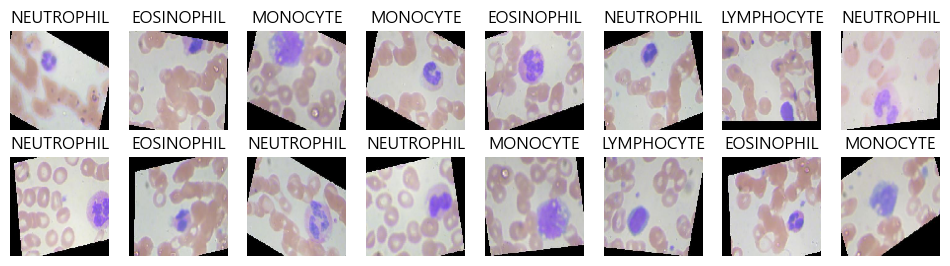

In [9]:
img, label = train_generator.next()
print(img.shape)

img = img[:16]
label = label[:16]

plt.figure(figsize=(12, 3))

for i in range(len(img)):
    plt.subplot(2, 8, i+1)
    plt.imshow(img[i])
    plt.axis("off")
    plt.title(list(train_generator.class_indices.keys())[int(label[i])])

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [2]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

NameError: name 'MobileNet' is not defined

In [11]:
start = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=val_generator)

end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/3
249/249 [==============================] - 99s 379ms/step - loss: 1.8432 - accuracy: 0.2917 - val_loss: 1.5067 - val_accuracy: 0.3323
Epoch 2/3
249/249 [==============================] - 99s 396ms/step - loss: 1.4551 - accuracy: 0.3495 - val_loss: 1.2446 - val_accuracy: 0.4268
Epoch 3/3
249/249 [==============================] - 97s 392ms/step - loss: 1.2847 - accuracy: 0.4040 - val_loss: 1.1398 - val_accuracy: 0.4952
걸린 시간 : 0:04:55.480473


In [ ]:
model.evaluate(test_generator)
model.evaluate(test_simple_generator)

In [ ]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

# 2. Project-2

- train과 test 데이터를 합쳐 섞은 후 재분리

In [ ]:
ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cells")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST_SIMPLE")

#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print("TEST")
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))
    
print("========================================================================")

#### 검증용 데이터 수 ####
simple_file_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print("TEST_SIMPLE")
print(simple_file_list)
for i in range(len(simple_file_list)):
    print(simple_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, simple_file_list[i]))))

### test디렉토리와 test_simple디렉토리의 모든 파일을 train 동일 디렉토리로 MOVE

In [ ]:
test_label_name = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name)

#### test ####
for label_name in test_label_name:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 이동시킬 데이터가 들어있는 경로
    test_file_list = os.listdir(test_path)                      # 이동시킬 데이터 담아두기
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)  # 이동된 데이터를 담을 경로
    
    move_num=0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num+=1
    print(str(move_num) + " is move into " + label_name + "(test -> train)")

#### val ####
simple_label_name = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(val_label_name)

for label_name in simple_label_name:
    simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)    # 이동시킬 데이터가 들어있는 경로
    simple_file_list = os.listdir(simple_path)                      # 이동시킬 데이터 담아두기
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)  # 이동된 데이터를 담을 경로
    
    move_num=0
    for simple_file in simple_file_list:
        shutil.move(os.path.join(simple_path, simple_file), os.path.join(train_path, val_file))
        move_num+=1
    print(str(move_num) + " is move into " + label_name + "(test_simple -> train)")

#### 이동완료된 test파일 데이터 수 확인 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_file_list)

for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

### Shuffle 후 test와 test_simple로 재이동

In [ ]:
MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

#### test ####
for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 목적 경로
    
    train_data_file_list = os.listdir(src)
    
    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num += 1
    print("move nums =>", move_num, "(train -> test)")

In [ ]:
#### test_simple ####
for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)    # 목적 경로
    
    train_data_file_list = os.listdir(src)
    
    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)
    
    test_simple_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for test_simple_data_file in test_simple_data_file_list:
        shutil.move(os.path.join(src, test_simple_data_file), os.path.join(dst, test_simple_data_file))
        move_num += 1
    print("move nums =>", move_num, "(train -> test_simple)")

In [ ]:
#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print("TRAIN")
print(train_file_list)
for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print("TEST")
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))
    
print("========================================================================")

#### 검증용 데이터 수 ####
simple_file_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print("TEST_SIMPLE")
print(simple_file_list)
for i in range(len(simple_file_list)):
    print(simple_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, simple_file_list[i]))))

### ImageDataGenerator을 이용해서 데이터 불러오기

In [ ]:
IMG_WIDTH = 100   # colab -> 224
IMG_HEIGHT = 100

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")
val_generator = val_data_gen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb", 
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

### 모델 학습

In [ ]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

In [ ]:
start = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=val_generator)

end = datetime.now()

print("걸린 시간 :", end-start)

In [ ]:
model.evaluate(test_generator)
model.evaluate(val_generator)

In [ ]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")